In [ ]:
!pip install sktime
import numpy as np
import pandas as pd
from scipy import stats

import statsmodels.api as sm
import statsmodels.tsa.api as tsa

from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

import plotly.express as px
from sktime.forecasting.structural import UnobservedComponents

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.9/36.9 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 17.5 MB/s eta 0:00:00


In [ ]:
sales_day = pd.read_csv('/5-6-1-daily-sales-data.csv',
                        index_col='date',
                        parse_dates=True,
                        dtype='float'
                        )

sales_day.index.freq = 'D'

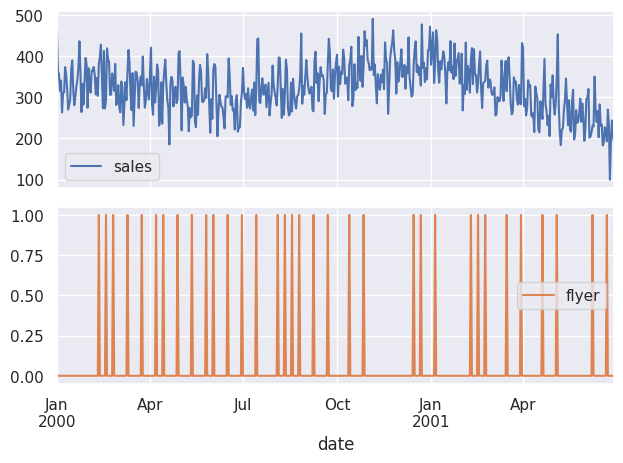

In [ ]:
sales_day.plot(subplots=True)
plt.tight_layout()

In [ ]:
px.line(sales_day.sales)

In [ ]:
sales_day_eda = sales_day.copy()

sales_day_eda['month'] = sales_day_eda.index.month

sales_day_eda['weekday'] = sales_day_eda.index.weekday

sales_day_eda.head(5)

,sales,flyer,month,weekday
date,,,,
2000-01-01,462.387217,0.0,1,5
2000-01-02,363.262237,0.0,1,6
2000-01-03,356.648654,0.0,1,0
2000-01-04,315.624792,0.0,1,1
2000-01-05,340.973428,0.0,1,2


In [ ]:
#lagを作る
sales_day['flyer_lag1'] = sales_day['flyer'].shift(1).fillna(0)
sales_day['flyer_lag2'] = sales_day['flyer'].shift(2).fillna(0)

In [ ]:
#祝日フラグ
holiday = pd.read_csv(
    'https://www8.cao.go.jp/chosei/shukujitsu/syukujitsu.csv',
    encoding='CP932', parse_dates=True, index_col=0
)

In [ ]:
#祝日フラグ
is_holiday = sales_day.index.isin(holiday.index).astype(int)
#年末年始フラグ
y_st = (sales_day.index.month == 1) & sales_day.index.day.isin([2, 3])
y_en = (sales_day.index.month == 12) & sales_day.index.day.isin([30, 31])

is_holiday = is_holiday + y_st + y_en

sales_day['holiday'] = is_holiday

In [ ]:
sales_day.head(5)

,sales,flyer,flyer_lag1,flyer_lag2,holiday
date,,,,,
2000-01-01,462.387217,0.0,0.0,0.0,1
2000-01-02,363.262237,0.0,0.0,0.0,1
2000-01-03,356.648654,0.0,0.0,0.0,1
2000-01-04,315.624792,0.0,0.0,0.0,0
2000-01-05,340.973428,0.0,0.0,0.0,0


In [ ]:
#祝日×日曜
sales_day['sun_holiday'] = is_holiday & (sales_day.index.dayofweek == 6)

In [ ]:
#基本構造時系列モデル
mod_bsts_1 = tsa.UnobservedComponents(
    sales_day['sales'],                       # 対象データ
    level='smooth trend',                     # 平滑化トレンド
    seasonal=7,                               # 7日間の周期
    exog=sales_day[['holiday', 'sun_holiday', # 外生変数
                    'flyer', 'flyer_lag1', 'flyer_lag2']]
)

# 最尤法によるパラメータの推定
res_bsts_1 = mod_bsts_1.fit(
    method='nm',              # Nelder-Mead法を使う
    maxiter=5000              # 最大繰り返し数
)

Optimization terminated successfully.
         Current function value: 4.954074
         Iterations: 1672
         Function evaluations: 2474


In [ ]:
print(res_bsts_1.params)

sigma2.irregular    1237.337343
sigma2.trend           0.005019
sigma2.seasonal        0.001131
beta.holiday          54.939879
beta.sun_holiday     -89.121117
beta.flyer            -5.851353
beta.flyer_lag1       58.599128
beta.flyer_lag2       27.070707
dtype: float64


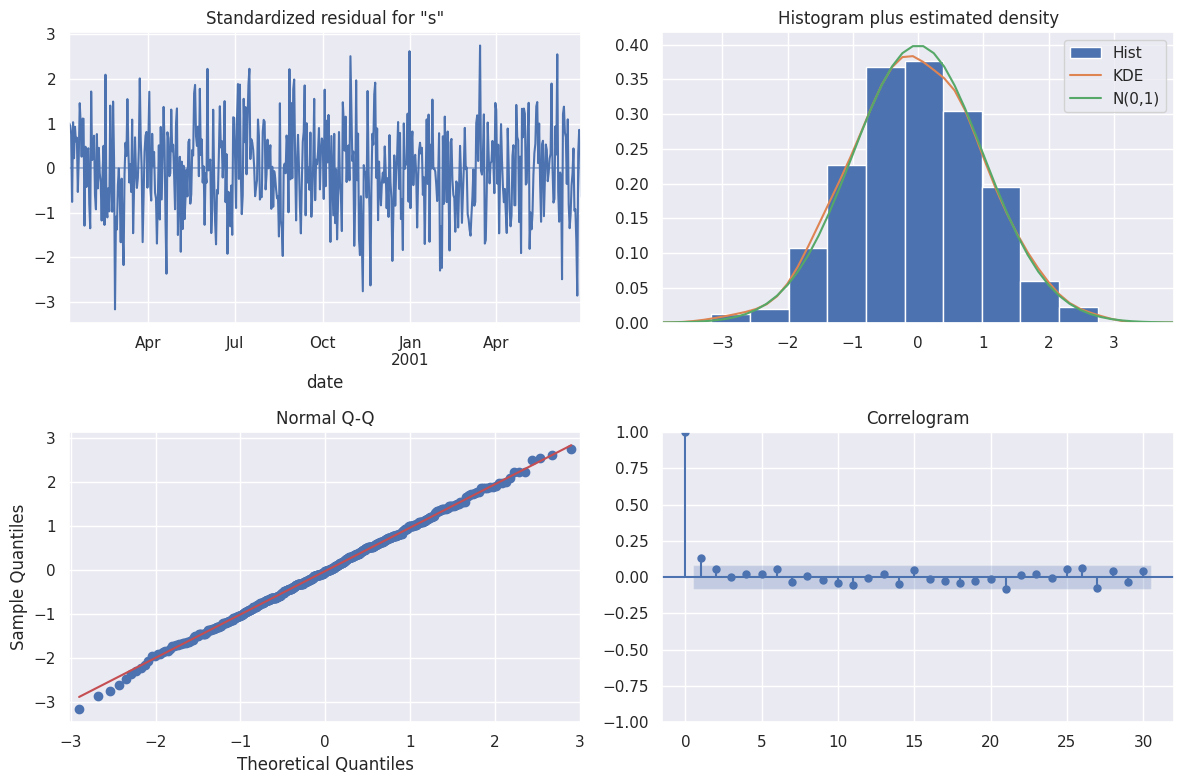

In [ ]:
_ = res_bsts_1.plot_diagnostics(lags=30, fig=plt.figure(tight_layout=True, figsize=(12,8)))

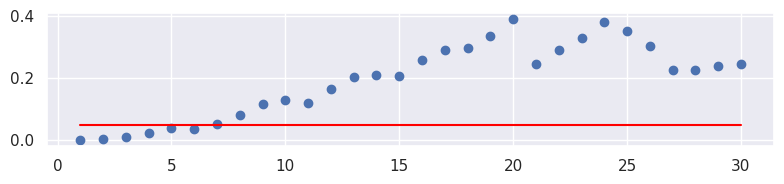

In [ ]:
#lag1に自己相関がみられる
#Ljung-Box検定をやってみる

res_test = res_bsts_1.test_serial_correlation(
    method='ljungbox',
    lags=30
)

fig, ax = plt.subplots(figsize=(8,2), tight_layout=True)

ax.scatter(np.arange(1,31), res_test[0][1])

ax.plot(np.arange(1, 31), np.tile(0.05, 30), color='red')

In [ ]:
#自己相関と長期季節性（１年）を踏まえた状態空間モデル
mod_bsts_2 = tsa.UnobservedComponents(
    sales_day['sales'],
    level='smooth trend',
    seasonal=7,
    exog=sales_day[['holiday', 'sun_holiday', 'flyer', 'flyer_lag1', 'flyer_lag2']],
    autoregressive=2,
    freq_seasonal=[{'period':365.25, 'harmonics':1}]
)

res_bsts_2 = mod_bsts_2.fit(
    method='nm',
    maxiter=5000
)

Optimization terminated successfully.
         Current function value: 4.926638
         Iterations: 4573
         Function evaluations: 6230


In [ ]:
print(res_bsts_2.params)

sigma2.irregular                  628.853681
sigma2.trend                        0.000633
sigma2.seasonal                     0.000005
sigma2.freq_seasonal_365.25(1)      0.000006
sigma2.ar                         523.596532
ar.L1                               0.290063
ar.L2                              -0.081568
beta.holiday                       42.675204
beta.sun_holiday                  -39.576943
beta.flyer                         -4.782871
beta.flyer_lag1                    45.615934
beta.flyer_lag2                    22.599119
dtype: float64


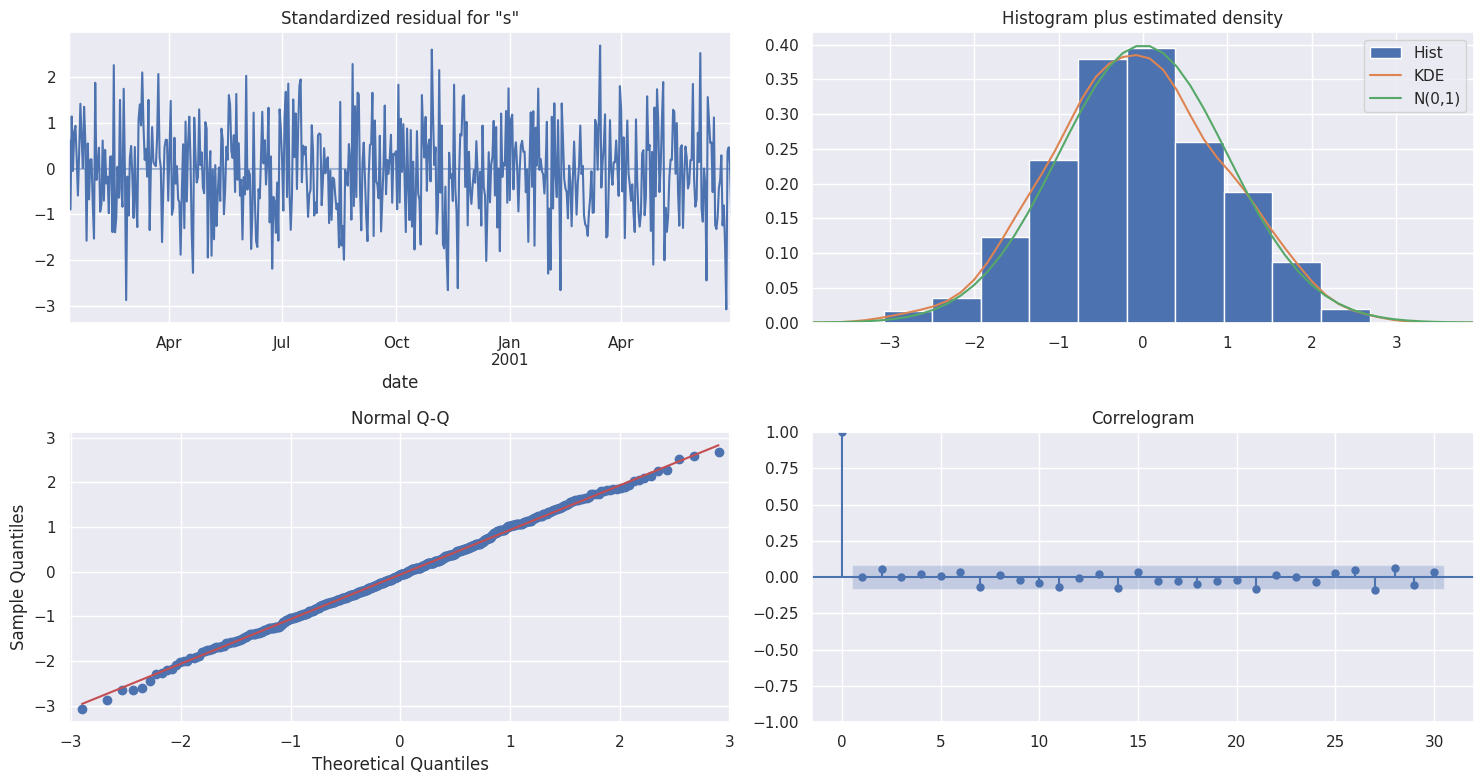

In [ ]:
_ = res_bsts_2.plot_diagnostics(lags=30, fig=plt.figure(figsize=(15,8), tight_layout=True))

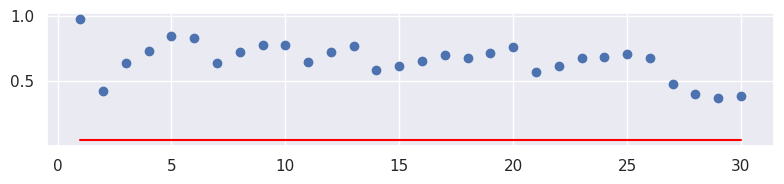

In [ ]:
#自己相関なさそうだし、残差は正規性を満たしてそう
#Ljung-Box検定をやってみる

res_test = res_bsts_2.test_serial_correlation(
    method='ljungbox',
    lags=30
)

fig, ax = plt.subplots(figsize=(8,2), tight_layout=True)

ax.scatter(np.arange(1,31), res_test[0][1])

ax.plot(np.arange(1, 31), np.tile(0.05, 30), color='red')

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning:

Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.



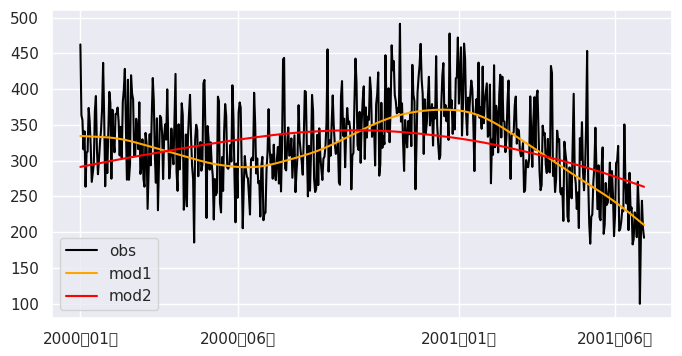

In [ ]:
plot_df = pd.DataFrame({'sales': sales_day['sales'],
                        'mod1_level': res_bsts_1.level['smoothed'],
                        'mod2_level': res_bsts_2.level['smoothed']})

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(plot_df['sales'], color='black', label='obs')
ax.plot(plot_df['mod1_level'], color='orange', label='mod1')
ax.plot(plot_df['mod2_level'], color='red', label='mod2')

ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator([1,6]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y年%m月'))